# Considerando as imagens satelitais, das mesmas regiões acima, contendo 8 canais espectrais (arquivos .tiff), implemente algum método para segmentação da vegetação presente nas cenas.

In [1]:
import numpy as np
import rasterio
from shapely.geometry import shape, mapping
import cv2
from utils import *


## Listando imagens

In [2]:
tif_files = list_files('../data/q2',['.tif'])
tif_dict = {os.path.basename(file).split('.')[0].split("_")[-1]:file for file in tif_files}

png_files = list_files('../data/q2',['.png'])
png_dict = {os.path.basename(file).split('.')[0].split("_")[-1]:file for file in png_files}



In [3]:
_8band_imgs = {}
for img_name, tif in tif_dict.items():      
    with rasterio.open(tif) as src:
        for i in range(1,9):
            if not img_name in _8band_imgs.keys():
                _8band_imgs[img_name]=[(src.read(i),f'{img_name}-chanel0{i}')]
            else:
                _8band_imgs[img_name].append((src.read(i),f'{img_name}-chanel0{i}'))
            


## Visualizando canais

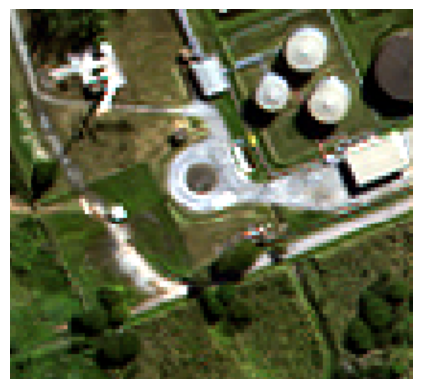

d:\msc\codes\satellite-image-case\questions\utils.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


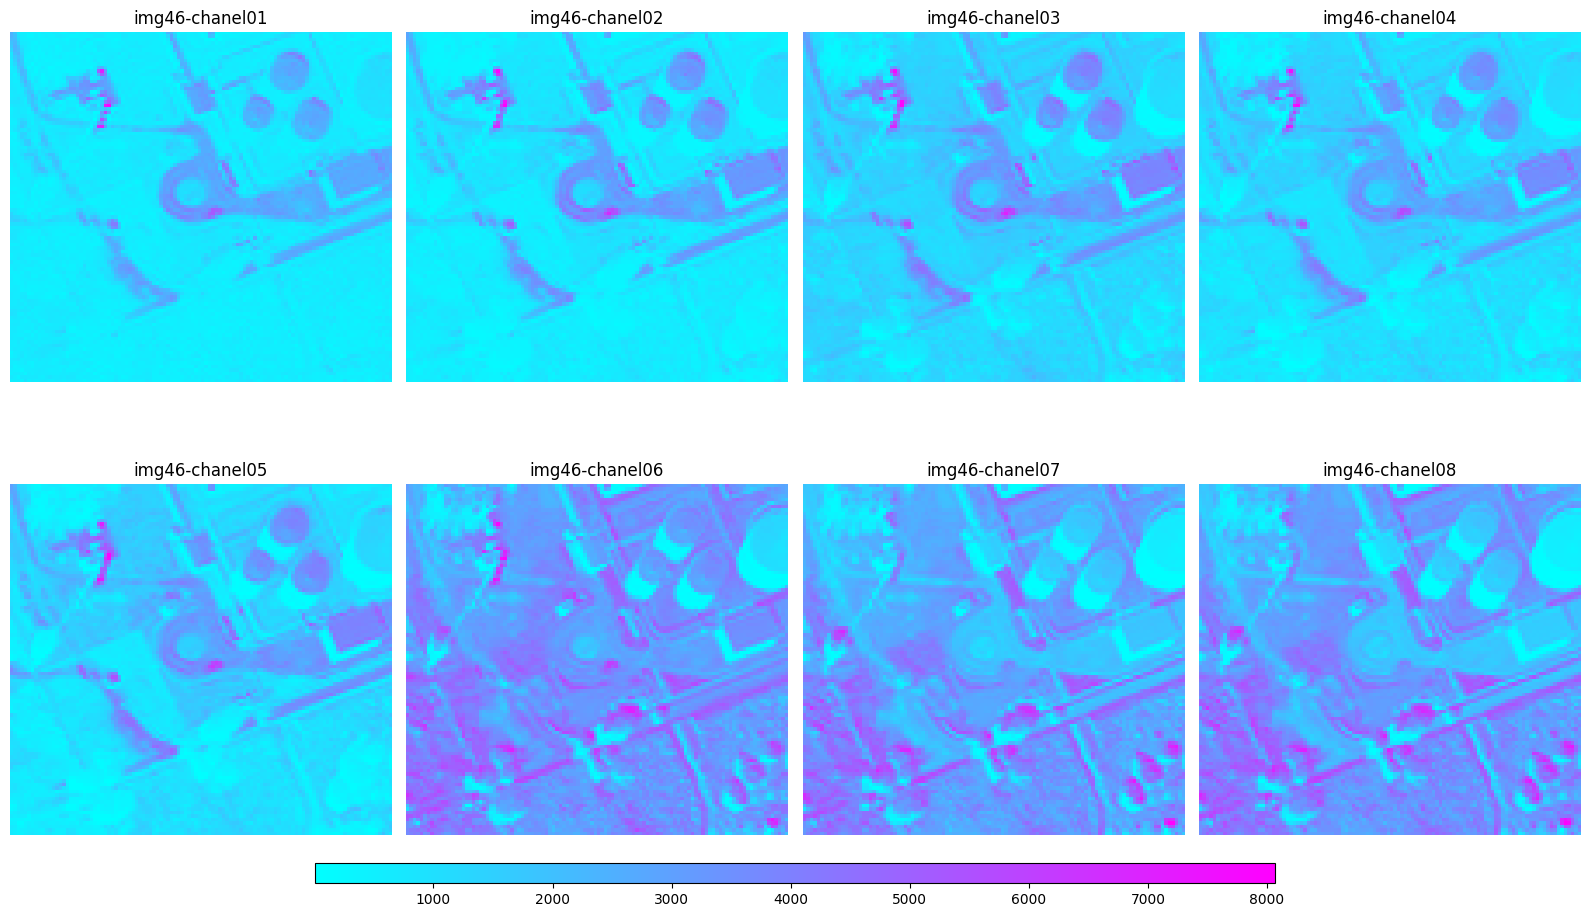

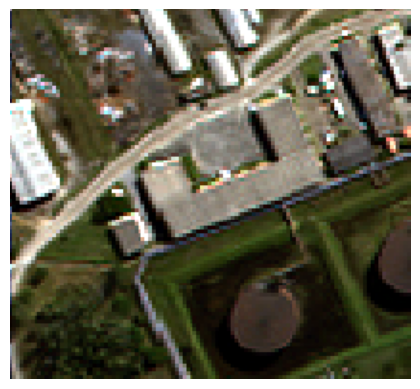

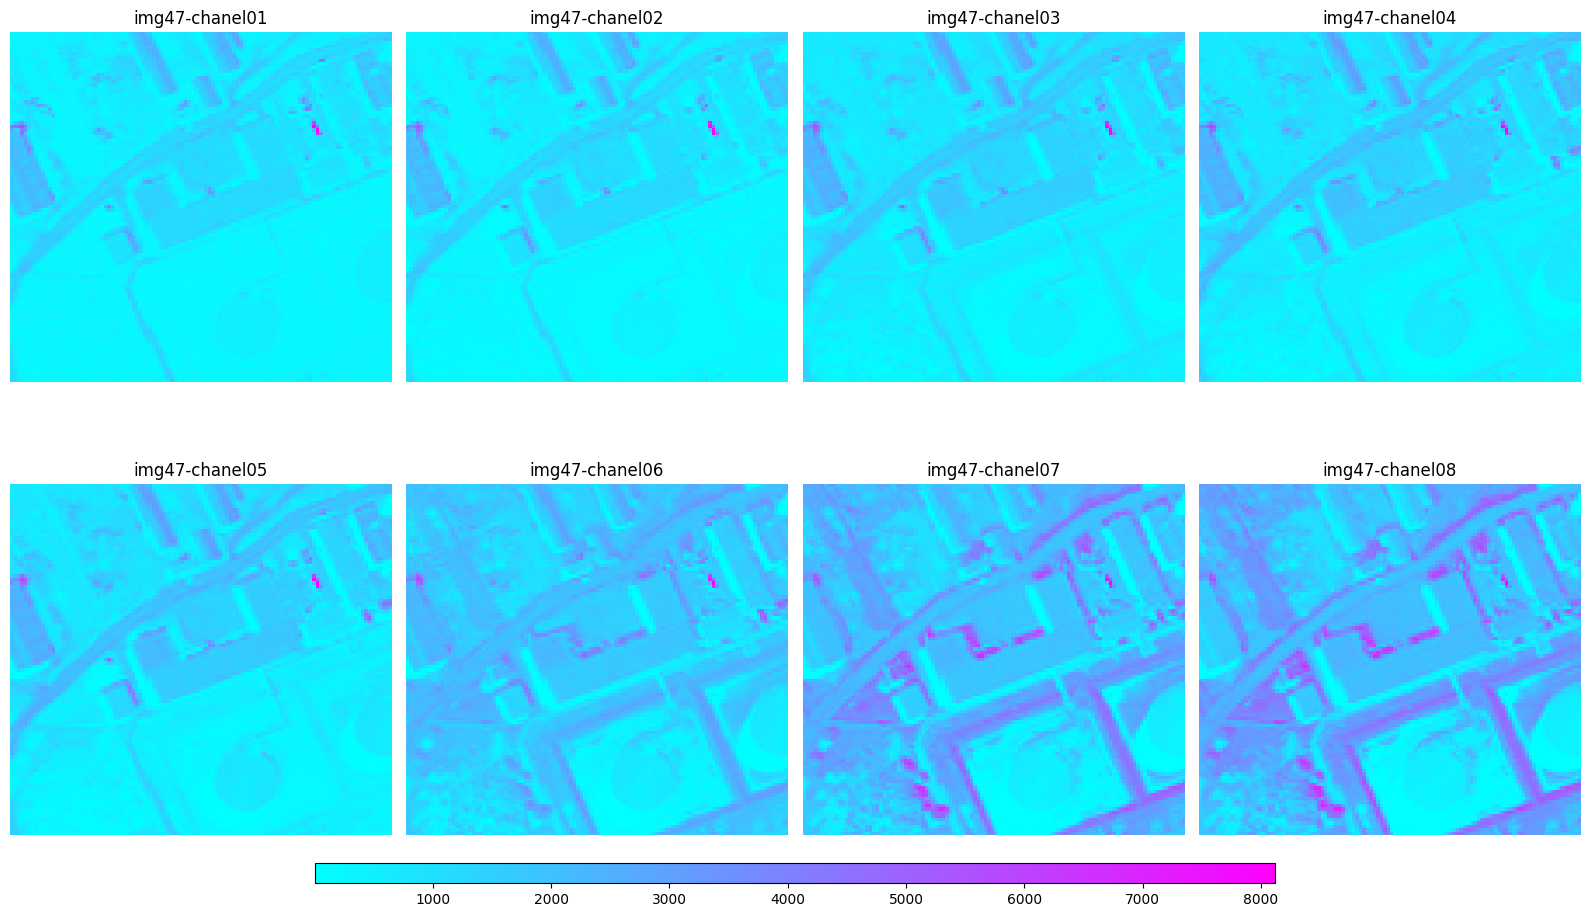

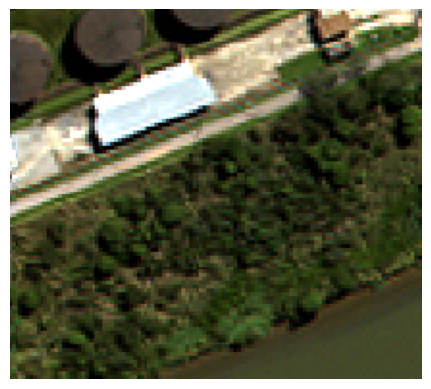

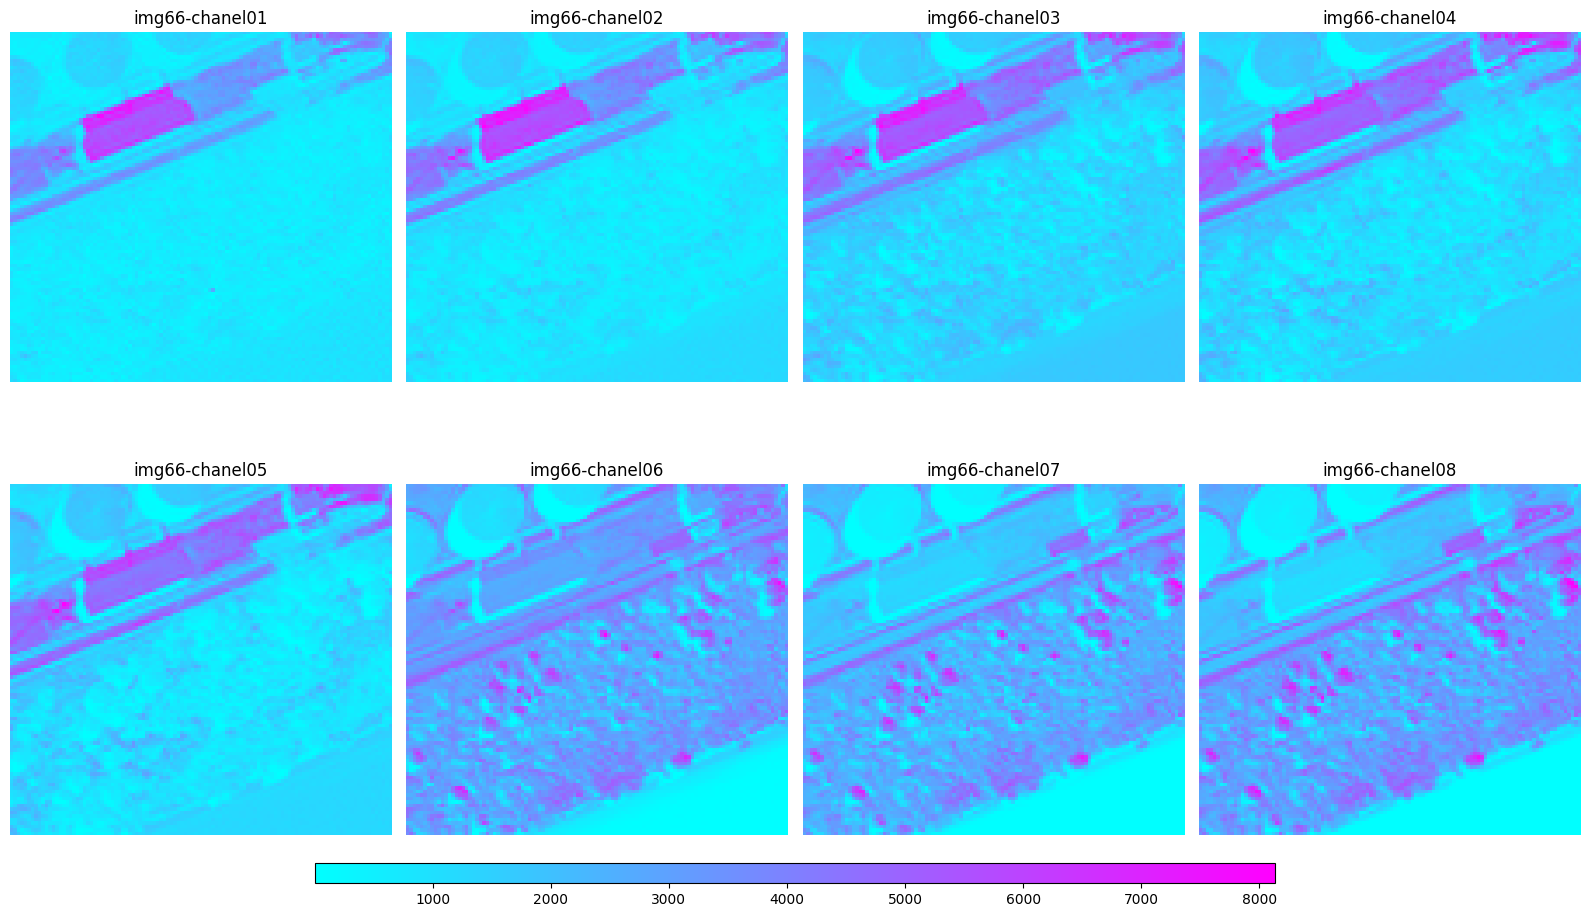

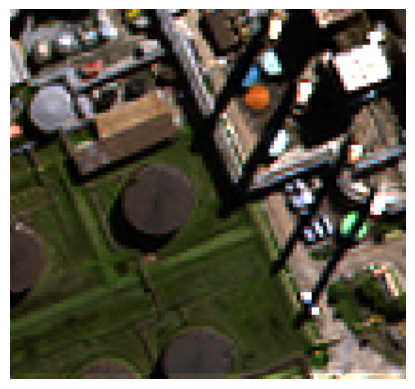

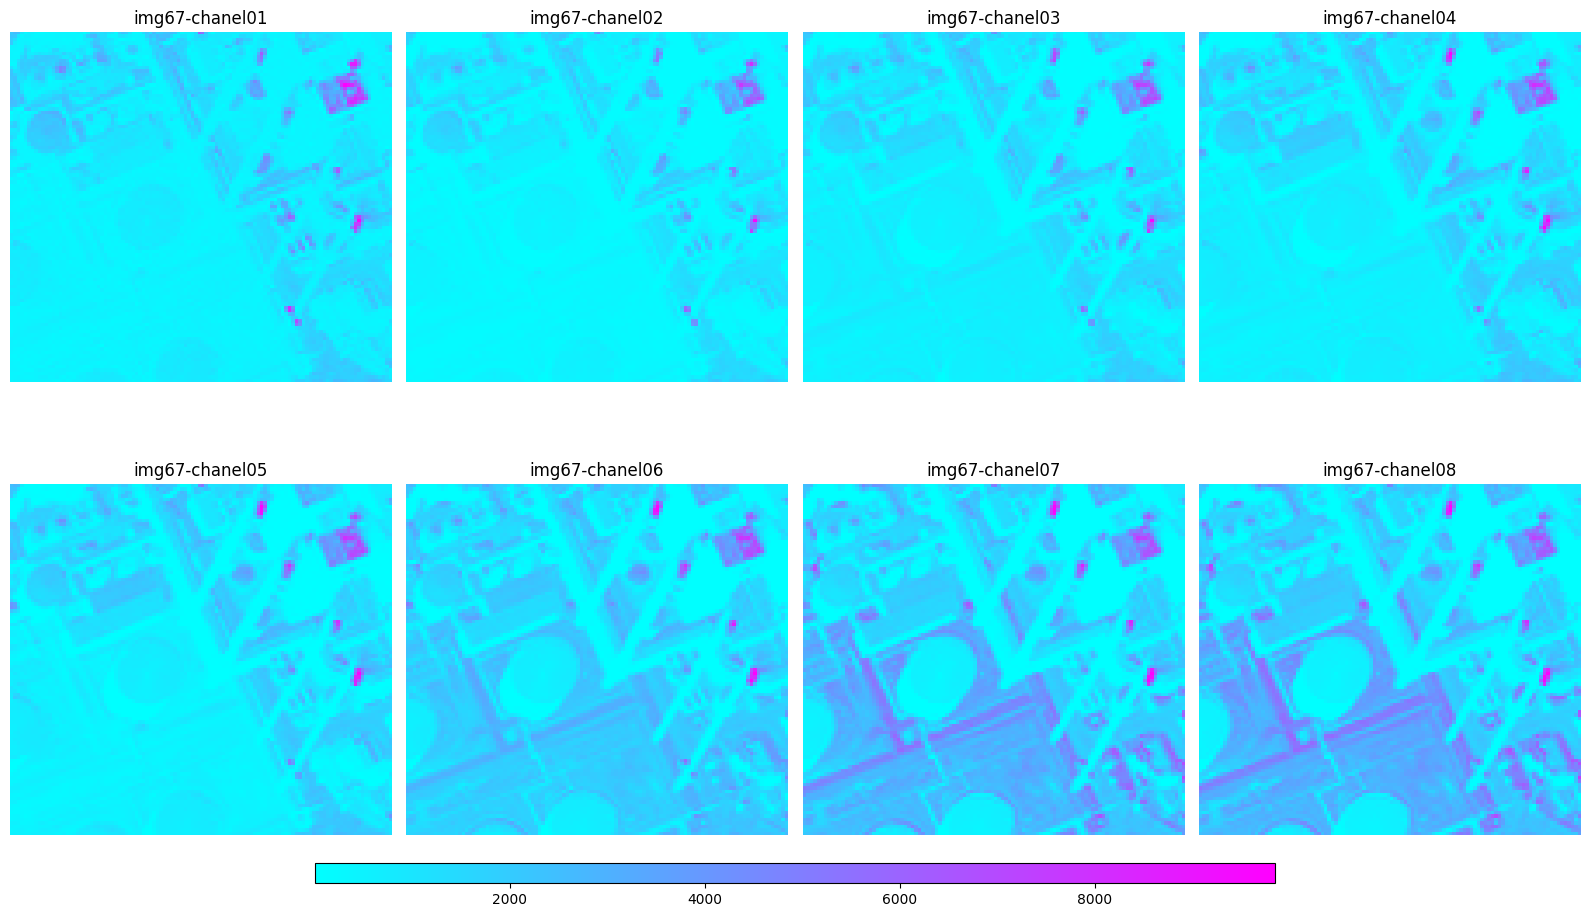

In [4]:
for key, value in _8band_imgs.items():    
    img_rgb = cv2.imread(png_dict[key])
    plt.imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
    plt.axis('off')  
    plt.show()
    plot_side_by_side(value,cmap='cool')

In [5]:
def create_tif_rgb(image_path):
    with rasterio.open(image_path) as src:        
        red_band = src.read(3)  
        green_band = src.read(2)  
        blue_band = src.read(1)  
    
    # Normalize the bands to the range 0-255
    red_band = (red_band / red_band.max() * 255).astype(np.uint8)
    green_band = (green_band / green_band.max() * 255).astype(np.uint8)
    blue_band = (blue_band / blue_band.max() * 255).astype(np.uint8)
    
    return cv2.merge([blue_band,green_band,red_band])


In [6]:
def compute_ndvi(image_path):   

    with rasterio.open(image_path) as src:
        nir_band = src.read(4)  
        red_band = src.read(3)     
    
    # Calculando NDVI
    return (nir_band - red_band) / (nir_band + red_band)    
    

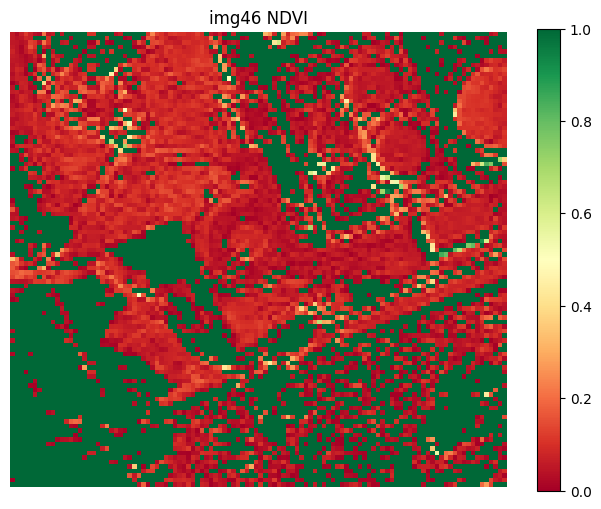

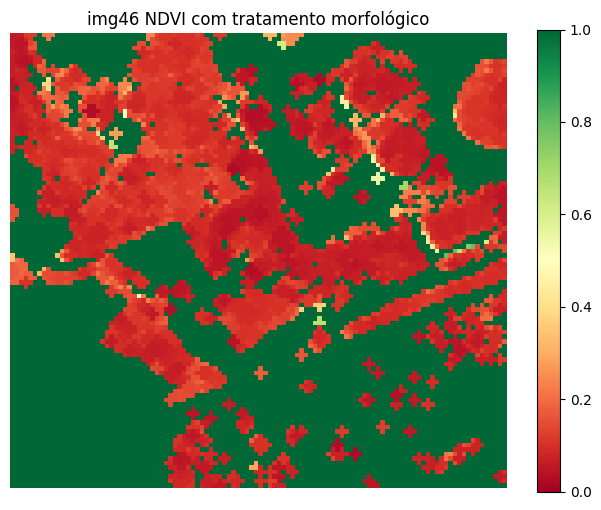

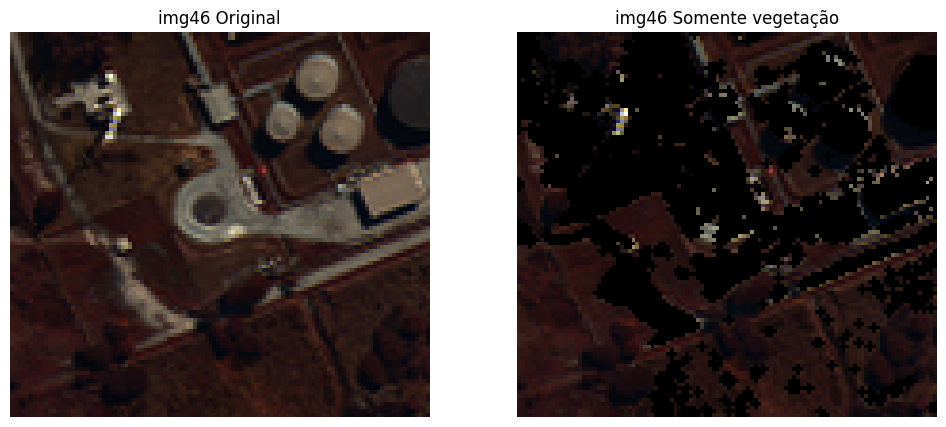

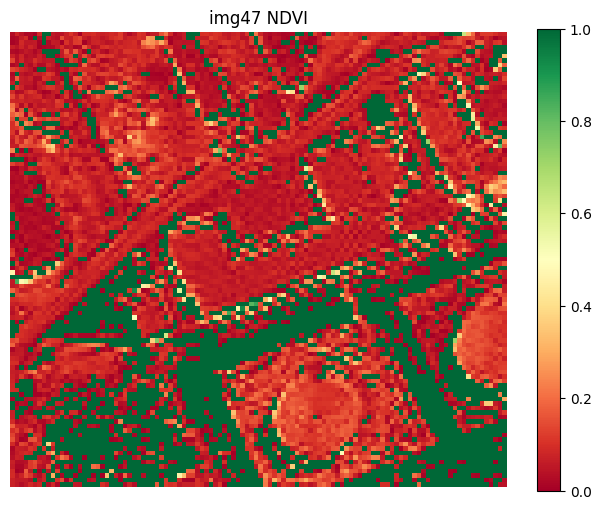

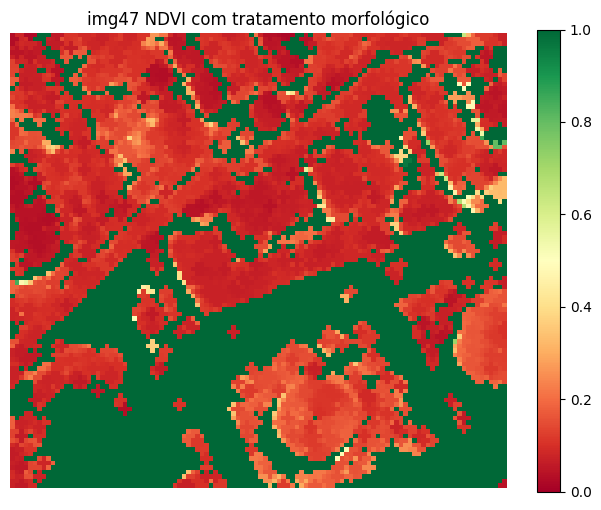

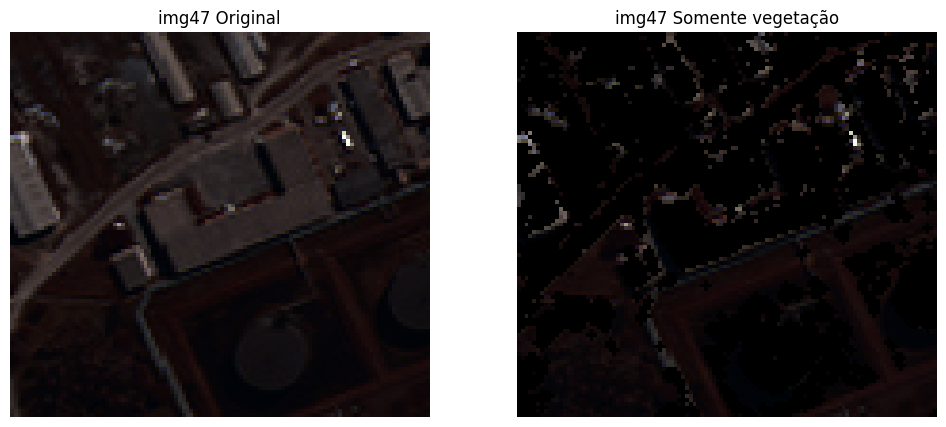

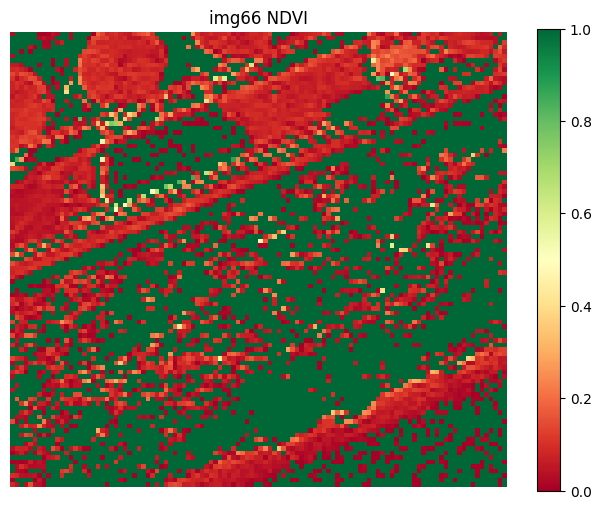

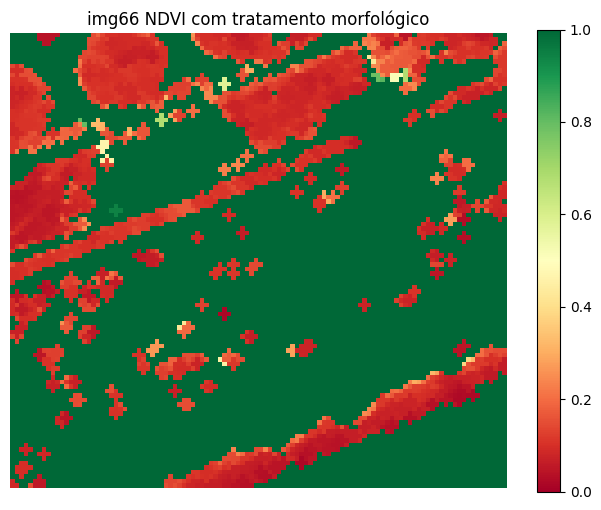

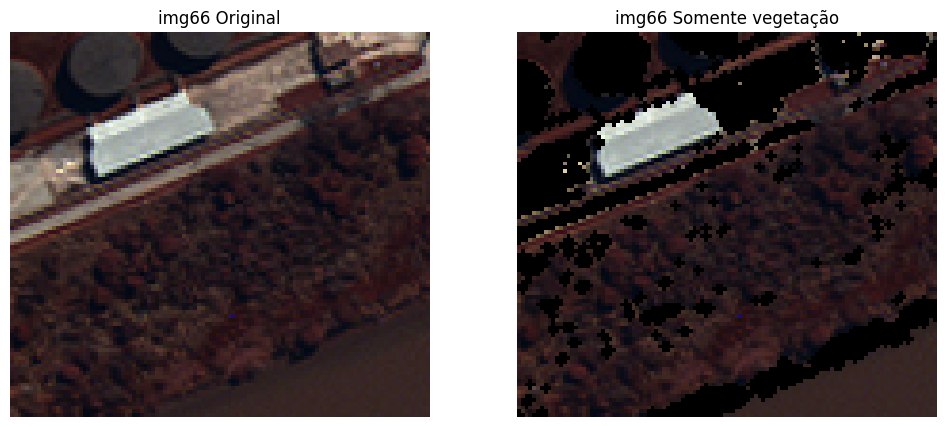

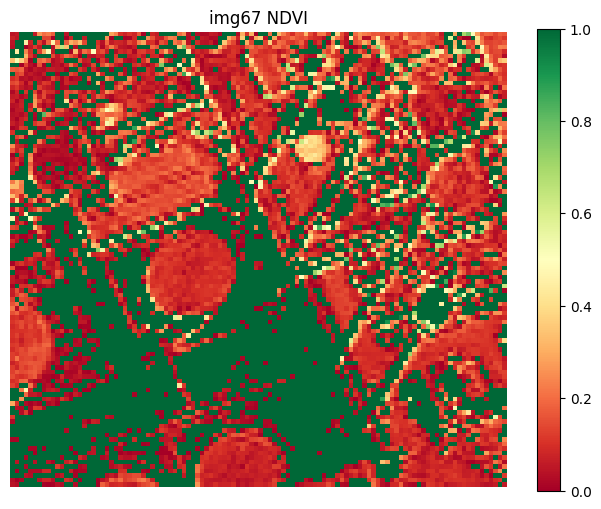

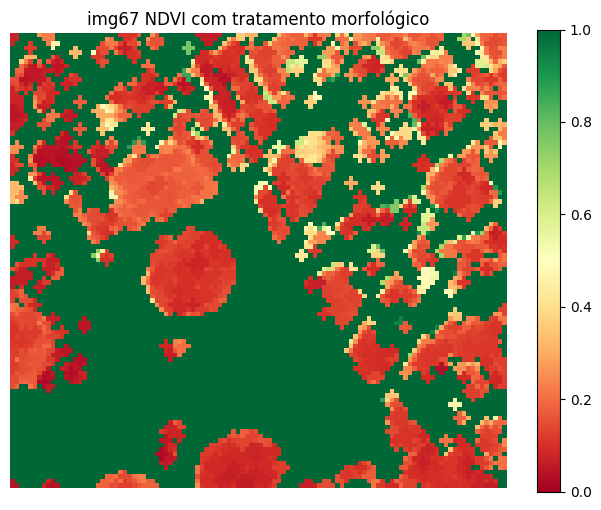

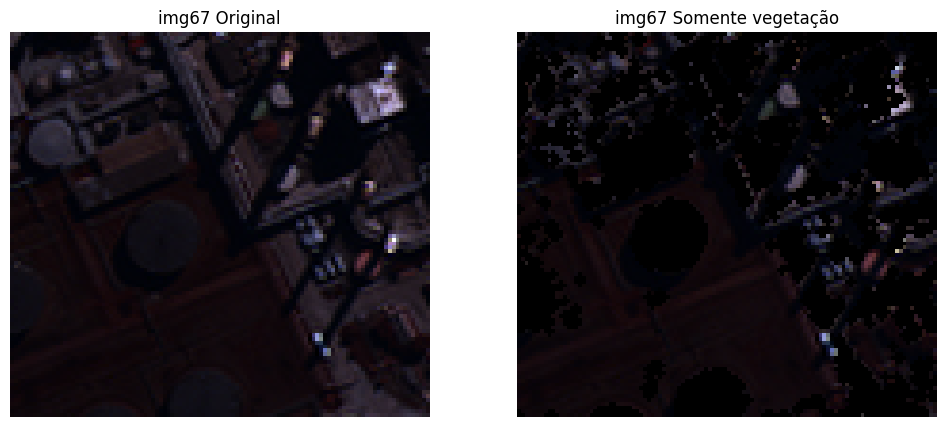

In [7]:

for img_name, tif in tif_dict.items():
    ndvi_tif  = compute_ndvi(tif)  
    rgb_tif = create_tif_rgb(tif)
    ndvi_morph = apply_dilate(ndvi_tif,k_size=3,_iterations = 1)           
    ndvi_morph = apply_erode(ndvi_morph,k_size=3,_iterations = 1)    
    
    #criando mascara de vegetação
    retval, veg_mask = cv2.threshold(ndvi_morph, 0.7, 1, cv2.THRESH_BINARY)  

    #aplicando mascara na imagem original
    only_veg = cv2.bitwise_and(rgb_tif.astype(np.uint8), rgb_tif.astype(np.uint8), mask=veg_mask.astype(np.uint8))
    
    # NDVI 
    plt.figure(figsize=(8, 6))
    plt.imshow(ndvi_tif, cmap='RdYlGn', vmin=0, vmax=1)
    plt.colorbar()
    plt.title(f'{img_name} NDVI')
    plt.axis('off')    
    plt.show()

    # NDVI com morfologia
    plt.figure(figsize=(8, 6))
    plt.imshow(ndvi_morph, cmap='RdYlGn', vmin=0, vmax=1)
    plt.colorbar()
    plt.title(f'{img_name} NDVI com tratamento morfológico')
    plt.axis('off')    
    plt.show()

    plot_side_by_side2([(cv2.cvtColor(rgb_tif,cv2.COLOR_BGR2RGB),f'{img_name} Original'),
                       (cv2.cvtColor(only_veg,cv2.COLOR_BGR2RGB),f'{img_name} Somente vegetação')])



## Conclusão
- Para se obter melhores resultados seria necessária entender melhor a radiometria da câmera, e até mesmo entender melhor o que cada banda representa.
- A img66 possui um estouro de pixels brancos (nas bandas RGB como mostrado na sesseão ## Visualizando canais)
- Seria interessante aplicar o indíce NDBI para explorar o problema de "segmentação" do silo q2a.ipynb
